In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import random

# =========================
# 1. Load Dataset from CSV
# =========================
df = pd.read_csv('combined_crop_disease_labels.csv')

# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Train-Test split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label_encoded'], random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['label_encoded'], random_state=42)

# Image generators
IMG_SIZE = (128, 128)
train_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    train_df, x_col='image_path', y_col='label', target_size=IMG_SIZE, class_mode='categorical', batch_size=32
)
val_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    val_df, x_col='image_path', y_col='label', target_size=IMG_SIZE, class_mode='categorical', batch_size=32
)
test_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    test_df, x_col='image_path', y_col='label', target_size=IMG_SIZE, class_mode='categorical', batch_size=32, shuffle=False
)

NUM_CLASSES = len(label_encoder.classes_)

# =========================
# 2. Base CNN Model Builder
# =========================
def build_cnn(lr=0.001, dropout_rate=0.5, filters_1=32, filters_2=64):
    model = models.Sequential()
    model.add(layers.Conv2D(filters_1, (3, 3), activation='relu', input_shape=(128, 128, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(filters_2, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

    optimizer = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# =========================
# 3. Dragonfly Algorithm (DA)
# =========================
def dragonfly_algorithm(obj_func, lb, ub, dim, pop_size=5, iterations=10):
    # Initialize dragonflies
    pos = np.random.uniform(lb, ub, (pop_size, dim))
    fitness = np.array([obj_func(ind) for ind in pos])
    best_idx = np.argmin(fitness)
    best_pos = pos[best_idx].copy()
    best_score = fitness[best_idx]

    for t in range(iterations):
        for i in range(pop_size):
            # Random movement
            step = np.random.uniform(-1, 1, dim)
            pos[i] += step
            pos[i] = np.clip(pos[i], lb, ub)

            fit = obj_func(pos[i])
            if fit < fitness[i]:
                fitness[i] = fit
                if fit < best_score:
                    best_score = fit
                    best_pos = pos[i].copy()

        print(f"Iteration {t+1}/{iterations} | Best Score: {best_score}")

    return best_pos, best_score

# =========================
# 4. Objective Function
# =========================
def fitness_function(params):
    lr, dropout_rate, filters_1, filters_2 = params
    filters_1 = int(filters_1)
    filters_2 = int(filters_2)

    model = build_cnn(lr=lr, dropout_rate=dropout_rate, filters_1=filters_1, filters_2=filters_2)
    history = model.fit(train_gen, validation_data=val_gen, epochs=2, verbose=0)  # short epochs for speed
    val_acc = history.history['val_accuracy'][-1]
    return 1 - val_acc  # minimize error

# =========================
# 5. Run DA Optimization
# =========================
lb = [1e-4, 0.2, 16, 32]  # Lower bounds: lr, dropout, filters_1, filters_2
ub = [1e-2, 0.7, 64, 128]  # Upper bounds

best_params, best_score = dragonfly_algorithm(fitness_function, lb, ub, dim=4, pop_size=3, iterations=5)
print("Best Parameters found by DA:", best_params)

In [4]:
# =========================
# 6. Train Final CNN with Best Params
# =========================
final_lr, final_dropout, final_f1, final_f2 = best_params
final_model = build_cnn(lr=final_lr, dropout_rate=final_dropout, filters_1=int(final_f1), filters_2=int(final_f2))
final_model.fit(train_gen, validation_data=val_gen, epochs=20)

# Test accuracy
loss, acc = final_model.evaluate(test_gen)
print(f"Final Test Accuracy: {acc:.4f}")

Epoch 1/20


/Users/simarkalsi/Projects/General Classification/disease/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1213/1213 ━━━━━━━━━━━━━━━━━━━━ 86s 70ms/step - accuracy: 0.1880 - loss: 2.9672 - val_accuracy: 0.5133 - val_loss: 1.5595
Epoch 2/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 85s 70ms/step - accuracy: 0.3926 - loss: 2.8527 - val_accuracy: 0.5964 - val_loss: 1.5132
Epoch 3/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 85s 70ms/step - accuracy: 0.4531 - loss: 3.4447 - val_accuracy: 0.6288 - val_loss: 1.5616
Epoch 4/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 85s 70ms/step - accuracy: 0.4931 - loss: 3.4229 - val_accuracy: 0.6463 - val_loss: 1.5733
Epoch 5/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 85s 70ms/step - accuracy: 0.5254 - loss: 3.3958 - val_accuracy: 0.6806 - val_loss: 1.5768
Epoch 6/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 85s 70ms/step - accuracy: 0.5384 - loss: 3.4616 - val_accuracy: 0.6929 - val_loss: 1.5083
Epoch 7/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 85s 70ms/step - accuracy: 0.5646 - loss: 3.3183 - val_accuracy: 0.6698 - val_loss: 1.7483
Epoch 8/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 85s 70ms/step - accuracy: 0.5747 - loss: 3.11

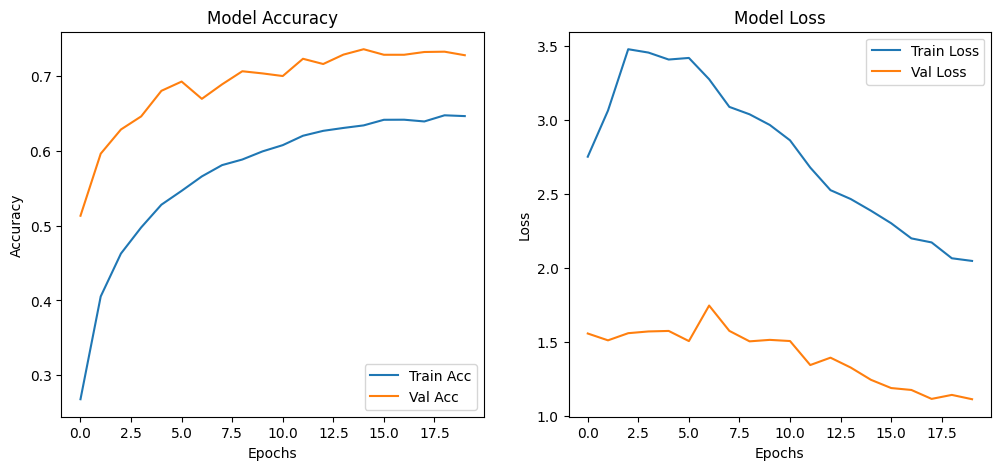

152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step


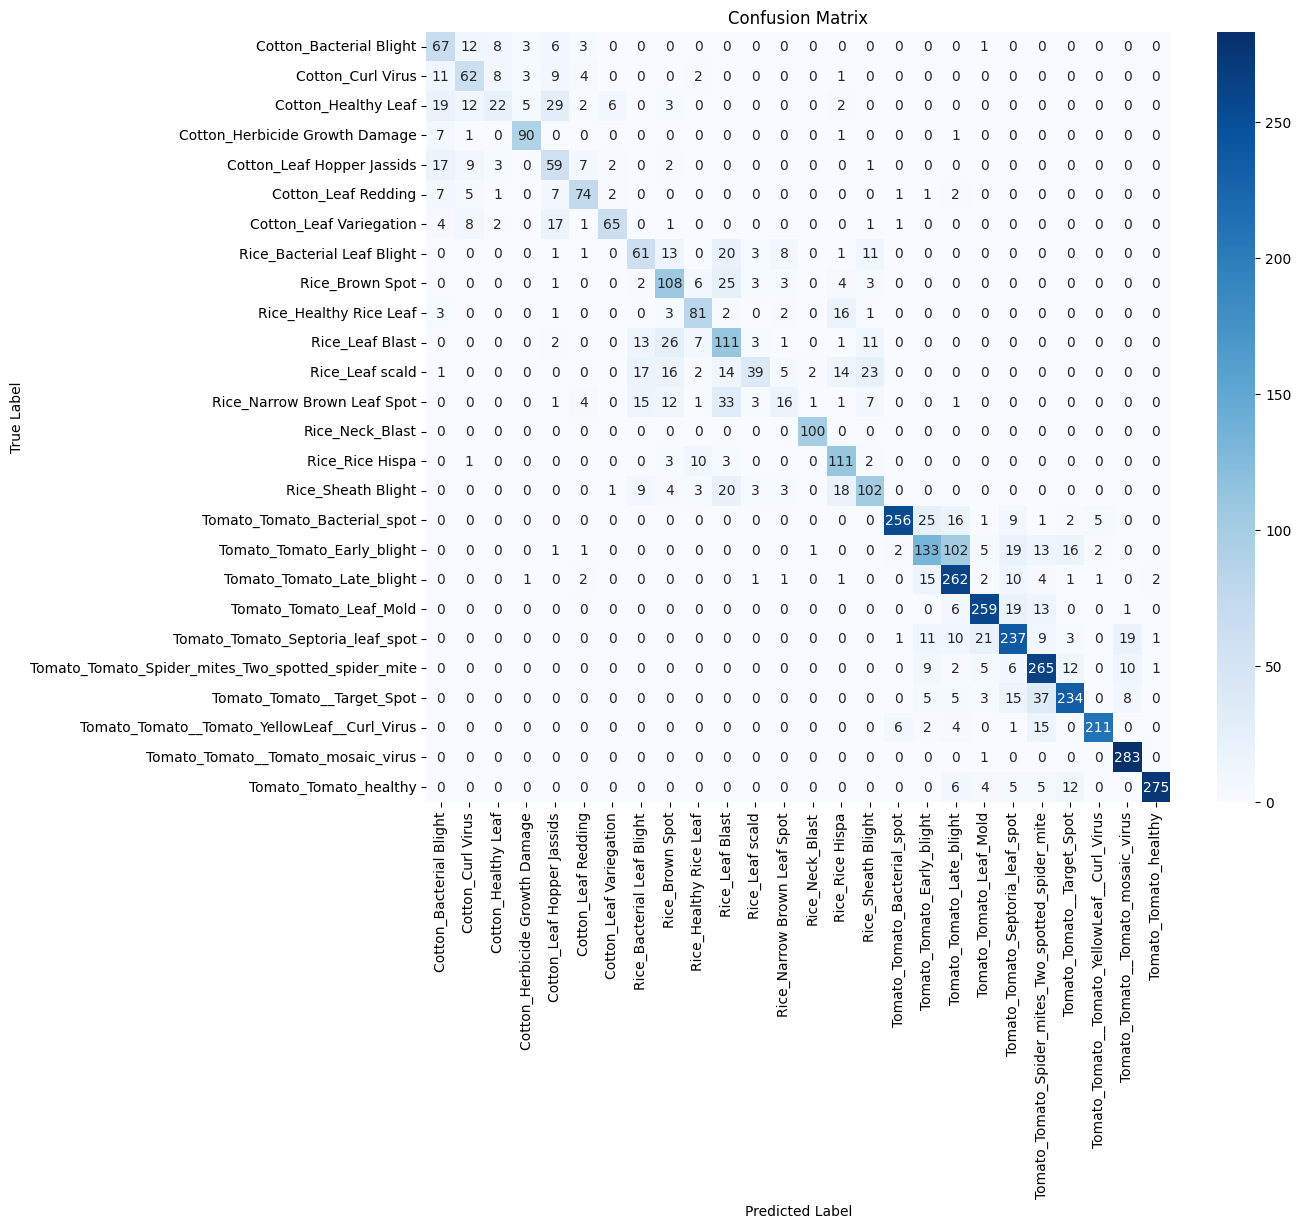


Classification Report:

                                                    precision    recall  f1-score   support

                           Cotton_Bacterial Blight       0.49      0.67      0.57       100
                                 Cotton_Curl Virus       0.56      0.62      0.59       100
                               Cotton_Healthy Leaf       0.50      0.22      0.31       100
                    Cotton_Herbicide Growth Damage       0.88      0.90      0.89       100
                        Cotton_Leaf Hopper Jassids       0.44      0.59      0.50       100
                               Cotton_Leaf Redding       0.75      0.74      0.74       100
                           Cotton_Leaf Variegation       0.86      0.65      0.74       100
                        Rice_Bacterial Leaf Blight       0.52      0.51      0.52       119
                                   Rice_Brown Spot       0.57      0.70      0.62       155
                            Rice_Healthy Rice Leaf    

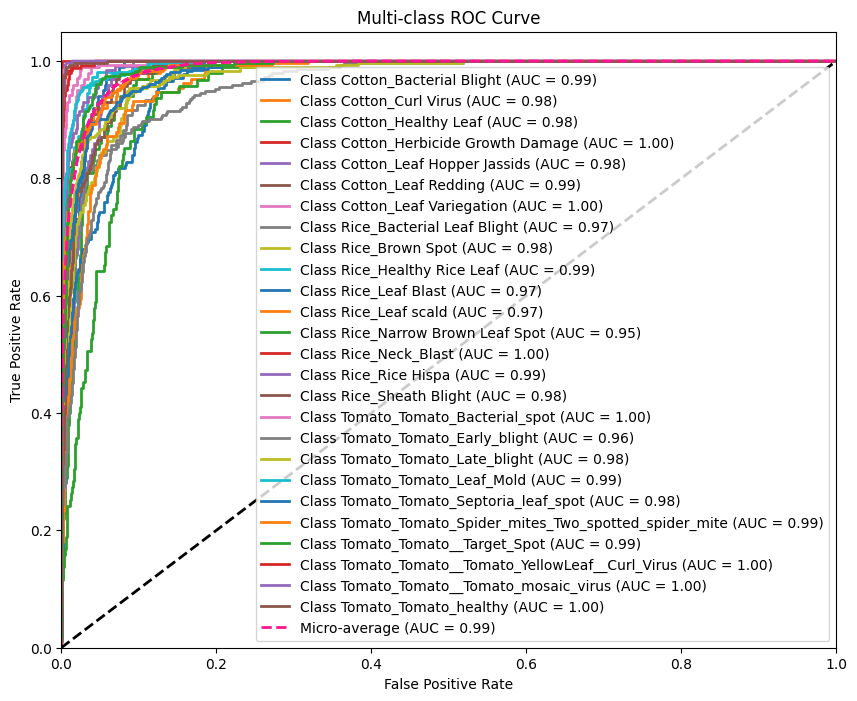

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
from itertools import cycle

# ====================================================
# 1. Plot Training Accuracy & Loss
# ====================================================
def plot_training_curves(history):
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()

    plt.show()

# ====================================================
# 2. Confusion Matrix & Classification Report
# ====================================================
def evaluate_model(model, test_gen, class_names):
    # Predict
    y_pred_probs = model.predict(test_gen)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_gen.classes

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification report
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

# ====================================================
# 3. Multi-class ROC Curve
# ====================================================
def plot_multiclass_roc(model, test_gen, class_names):
    y_score = model.predict(test_gen)
    y_true = label_binarize(test_gen.classes, classes=list(range(len(class_names))))

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(10, 8))
    colors = cycle(plt.cm.tab10.colors)

    for i, color in zip(range(len(class_names)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle='--',
             label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})', lw=2)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# ====================================================
# 4. Run All Evaluations
# ====================================================
# Plot accuracy/loss curves from final training
plot_training_curves(final_model.history)

# Get class names
class_names = list(label_encoder.classes_)

# Evaluate model
evaluate_model(final_model, test_gen, class_names)

# Plot multi-class ROC
plot_multiclass_roc(final_model, test_gen, class_names)
